# <center>Big Data for Engineers – Exercises</center>
## <center>Spring 2021 – Week 7 – ETH Zurich</center>
## <center>Map Reduce - solutions </center>

This week we will review _MapReduce_—a programming model and distributed system for processing datasets in parallel over large clusters. We will first discuss the two APIs that can be used to write MapReduce jobs. Then, we willimplement a MapReduce job in Python. Finally, we will discuss relevant theory bits behind MapReduce.

## 0. The two APIs for MapReduce

MapReduce provides two different interfaces: the **native MapReduce API** and the **Streaming API**.

The native MapReduce API is equivalent to the one seen in class. To use it, the user has to write two Java classes: one for the Mapper function and one for the Reducer function. Just like in the logical model:

- the Mapper function takes a KeyValue pair and emits zero or more KeyValue pairs;
```js
function map(key, value)
  // Do some work
  emit(someKey, someValue)
```
- and the Reducer function takes a key and a collection of values, and emits zero or more KeyValue pairs (usually one). 
```js
function reduce(key, values[])
  // Do some work
  emit(key, aggregatedValue)
```
  
The Streaming API is usually slower, but allows users to write the Mapper and the Reducer functions in any language — even different languages.
To use the API we need to write two functions, a mapper and a reducer. In this case, however, the programs will directly read the KV pairs as a sequence of lines from standard input and write the resulting KV pairs to standard output.
The streaming API will take care of all the parallelization, the shuffling and everything else required.
Since the operations are done using the standard input and standard output, there are two differences with the logical model:

1. The KV pairs are not independently processed, but read all **sequentially** from standard input.
2. The reducer task does not receive a key with a list of values, but the **ordered list** of KV pairs (one per line). Therefore, the reducer must therefore implement itself the logic for handling a new key. 

## 1. Hands on

In this first part of the exercise session, we will obtain some practical experience with MapReduce. To do so, we will create a cluster on Azure as usual, then write a MapReduce job in Python and use the Hadoop Streaming API to run the code on the cluster.

### 1.1 Create the cluster

By now you are an expert with Azure! Today, we are going to create an HDInsight cluster running Hadoop.

**Important:** we want you to use a small but real cluster for running HBase rather than a single machine. But, these clusters burn Azure credit very quickly—the cheapest configuration consumes roughly **2 CHF per hour**, which is a lot relative to your overall credit—so it is very important for you to **delete your cluster once you are done.** Luckily, it is possible to keep your data intact when you delete a cluster, and see it again when you recreate it; we will touch upon this in the process. Now, let's start. Those steps are very similar to the HDFS cluster we create on week 3.

1. In Azure portal click the **"Create a resource"** button on the left, type **"hdinsight"** in the search box, and select **"Azure HDInsight"** and click **"Create"**. HDInsight is Microsoft's cloud service which wraps Hadoop, HBase, Spark and other Big Data technologies; read more [here](https://azure.microsoft.com/en-us/services/hdinsight/).

1. In the **"Basics"** tab, choose a subscription and **create a new resource group** (say "exercise7"). Pick a name for your cluster, select **UK South** as the region, **Hadoop** as the cluster type. Then, setup the cluster login username and password, as well as the SSH username.
![basics](https://bigdataforengineers2021.blob.core.windows.net/exercise07/basics.png)  

1. Next, we need to configure the **"Storage"** tab. The canonical way would be to use an HDFS cluster as a storage layer for a Hadoop cluster, but we will be using the Blob service of Windows Azure Storage for this purpose. This has a significant advantage of allowing you to delete your HBase cluster without losing the data: you can recreate the cluster using the same Azure Storage Account and the same container and you will see the same data. This is useful, for example, if you don't have time to finish this exercise in one sitting: you can just delete your cluster, recreate it later, and continue your work. Azure storage is selected by default (see the screenshot).  
To setup your Hadoop cluster for the first time, in **"Primary storage account"** click **"Create new"** and specify a name. Leave everything else as it is and click "Next".
**Important**: if you are recreating your Hadoop cluster and want to see the existing data, then choose **"Select existing"** and set the container name to the one that you used last time—by default Azure generates a new container name every time you create a cluster, which then points to a different container. The container name can be found in "Storage account - containers".
![storage](https://bigdataforengineers2021.blob.core.windows.net/exercise07/storage.png)  

1. In the "Security + networking" tab do not choose anything, just click "Next: Configuration + pricing".

1. Now we need to choose the configuration of the nodes in our HBase cluster. Let's choose **2 Head nodes** of size **D3 v2**, and **4 Worker nodes** of size **D3 v2** (see the screenshot). Click **"Review + create"**.
![pricing](https://bigdataforengineers2021.blob.core.windows.net/exercise07/pricing.png)  

1. In the last step, "Summary", check if the settings are as you intend. These clusters are expensive, so it is worth checking the price estimate at this step: for me it is 1.74 CHF/hour; if your price is larger than this, check your node sizes and counts. When done, initiate the cluster creation by clicking "Create". The process will take time, around 15—25 minutes.

### 1.2 Accessing your cluster
To connect to the cluster we run the `ssh` program in a terminal. This process is the same as in last week's HDFS exercise, but we will repeat the instructions here for convenience.

There are three options as to how you can do this:
1. **On your own machine** you can just use a normal terminal if you have `ssh` installed. Linux usually has it, as does MacOS. Windows doesn't have it by default (although Windows 10 does since recently), but you can use one of the browser-based options described next, or the other option is to install [PuTTY](http://www.putty.org/).
1. **In your browser:**
  1. Use the **Azure Cloud Shell**. Click on the Cloud Shell icon at the top of Azure Dashboard toolbar. It will request your approval for creating a Storage Account required for the shell; agree to it.
  1. Use a **terminal on Jupyter**. In your [notebooks.azure.com](https://notebooks.azure.com) tab, click "My Projects" in the upper-left corner of the page. Then, select any project and click "Terminal".

In your terminal of choice, run the following (this command with everything filled-in is also available on the Azure page of your cluster, if you click "Secure Shell (SSH)"): 

`ssh ssh_user_name@cluster_name-ssh.azurehdinsight.net`

In this command, `ssh_user_name` is the "ssh username" that you have chosen in the first step of creating the cluster, and `cluster_name` also comes from that form. Note that the cluster name has to be suffixed with `-ssh`. 

If after running the `ssh` command you see a message similar to this:
```
Welcome to Hadoop on HDInsight.

Last login: Sat Oct 14 15:56:56 2017 from 180.220.17.157
To run a command as administrator (user "root"), use "sudo <command>".
See "man sudo_root" for details.

<ssh_user_name>@hn0-cluster:~$
```
then you have successfully connected to your cluster.

### Troubleshooting
Some issues may arise while creating your HBase cluster. Here are some common issues that we experienced:
1. *StorageAccountAlreadyExists* : Make sure to use a unique name while creating a new storage account. The portal does not check for this while in the creation panel but only on validation and an error will arise. This also holds for cluster names.
1. *The ssh connection does not work* : Use the password that you provided at creation. If you can't retrieve it, you can reset the password in the ssh+keys panel of your Hbase cluster. Also if you are recreating a new cluster, use a different name as your past created cluster. Otherwise, this may create a conflict in your local *known_hosts* configuration file.

You can find more information about deployement errors on [this page](https://docs.microsoft.com/en-us/azure/azure-resource-manager/resource-manager-common-deployment-errors).&lt;/ssh_user_name&gt;&lt;/cluster_name&gt;&lt;/ssh_user_name&gt;&lt;/cluster_name&gt;&lt;/ssh_user_name&gt;

### 1.3 Writing the mapper and the reducer functions

To run a MapReduce job we need of course a mapper function and a reducer. Usually to run natively on Hadoop we need to write our mapper and reducer as classes in Java, but to make the development easier and less cumbersome we are going to use the **Hadoop streaming API**.  
This wonderful API allows the developers to write code in any language and integrate it seamlessly with the MapReduce framework.  
We just need to provide 2 scripts—one for the mapper, one for the reducer—and let them read the KeyValues from `stdin` (the default input stream) and write them to `stdout` (the default output stream). Hadoop will take care of parallelization, the sort step and everything else required.  

To start we will just use the HelloWorld for MapReduce programs, which is WordCount: given a list of files, return for each word the total number of occurrences.  

From the ssh console run:

`wget https://bigdataforengineers2021.blob.core.windows.net/exercise07/mapper.py`  
`wget https://bigdataforengineers2021.blob.core.windows.net/exercise07/reducer.py`

to get the file on the cluster, if you want to edit them or create a new file you can use the simple console text editor `nano` (its commands are indicated at the bottom of its interface, e.g. `^X Exit` means `use Ctrl+X to exit`).

Before continuing we need to ensure that the files are actually executable so they can be run by the MapReduce job  
`chmod +x ./reducer.py ./mapper.py`.

Let's take a closer look at the files:

```python
#!/usr/bin/env python
"""mapper.py"""

import sys
import re

for line in sys.stdin:
    # Set to lowercase, remove punctuations and tokenize
    line = line.lower().strip()
    line = re.sub(r"[^\w\s]", "", line)
    words = line.split()
    for word in words:
        print '%s\t%s' % (word, 1)
```
For the mapper the first line starting with `#!` tells to Hadoop how to run the script (using Python in this case), then for each line in our input (automatically directed to the `sys.stdin` stream by Hadoop) we remove leading and trailing whitespaces, then split the line on each whitespace and 'emit' a key-value pair made up of a word and the unit count one.

```python
#!/usr/bin/env python
"""reducer.py"""

from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

for line in sys.stdin:
    line = line.strip()
    word, count = line.split('\t', 1)
    try:
        count = int(count)
    except ValueError:
        continue

    if current_word == word:
        current_count += count
    else:
        if current_word:
            print '%s\t%s' % (current_word, current_count)
        current_count = count
        current_word = word

if current_word == word:
    print '%s\t%s' % (current_word, current_count)
```
For the reducer we receive an ordered list of key-value pairs generated by the mapper and then sorted automatically, so for each line in the input stream, we remove leading and trailing whitespaces, we split the line into the word and the count (always 1 if we used the previous mapper and no combiner), then try to convert the count (by default a string) to a number (and skipping the value in case of failure).  
After that if the word is equal to the previous one (remember the kv pairs are sorted so all the same words will be together) we just increase the count for that word by one, otherwise we print the current word with the associated count and move to the next word.

### 1.4 Test correctness of your program locally

Since a MapReduce job on a cluster usually requires a considerable amount of time, before launching it we want to test our functions locally.  
To do so we can simulate our MapReduce job by inputting the data to the mapper, properly sorting the output of that and feeding it into the reducer, then checking that we get the expected result.  

We can try with   `echo "foo foo quux labs foo bar quux" | ./mapper.py | sort -k1,1 | ./reducer.py`.

### 1.5 Get some data

Download on the cluster some nice books on which we will run our MapReduce job (btw some of these are really nice)
```
wget http://www.gutenberg.org/cache/epub/2500/pg2500.txt 
wget http://www.gutenberg.org/files/1342/1342-0.txt
wget http://www.gutenberg.org/files/84/84-0.txt
wget http://www.gutenberg.org/files/2600/2600-0.txt
wget http://www.gutenberg.org/files/74/74-0.txt
wget http://www.gutenberg.org/files/2591/2591-0.txt
wget http://www.gutenberg.org/files/4300/4300-0.txt
```

and put them on HDFS
```
hadoop fs -mkdir /tmp/books
hadoop fs -copyFromLocal ./*.txt /tmp/books
```

### 1.6 Run the MapReduce job
Finally we are ready to run our MapReduce job:  
```
hadoop jar /usr/hdp/current/hadoop-mapreduce-client/hadoop-streaming.jar \
-mapper mapper.py \
-reducer reducer.py \
-input /tmp/books/* \
-output /tmp/output-folder \
-file reducer.py \
-file mapper.py    
```

This command allows us to use the streaming API from Hadoop. We need to pass each file used, the mapper and the reducer and finally the input files and the output folder (__the output folder must be a new non-already-existing folder__).  
We can pass additional configuration parameters, namely we can ask Hadoop to use a certain number of reducers by setting the `numReduceTasks` command-line argument 
```
hadoop jar /usr/hdp/current/hadoop-mapreduce-client/hadoop-streaming.jar \
-numReduceTasks 4 \
-mapper mapper.py \
-reducer reducer.py \
-input /tmp/books/* \
-output /tmp/output-folder-2 \
-file reducer.py \
-file mapper.py    
```


### 2.3. Download and plot the results
The output of the MapReduce process has been stored in your remote cluster. You can now download the result file and plot the frequency of the 30 most common words in the dataset. The easiest way for this notebook to be able to access your result file is to set your container as *public*. 

By default, output files have the form `part-A-XXXX` where `A` is *r* or *m* to denote Reducer or Mapper outputs, and `XXXX` is the id of the specific mapper or reducer task.

<img src="https://bigdata2020exassets.blob.core.windows.net/ex07/container.png" style="width:500px;">

- Access the MapReduce container in portal.azure.com.
- Set the Access Policy of the container to public.
- Locate the result file in /tmp/output-folder/ and copy the file URL. The link should be now accessible from your browser.
- Add the URL below, run to download the file and plot the results.

In [1]:
RESULT_FILE_URL = '...'
import urllib.request
urllib.request.urlretrieve (RESULT_FILE_URL, "results.txt")
print ('Done downloading')

Done downloading


By reading word counts from results.txt, find the 30 most frequent words in the dataset 

##### Solution

Plotting...


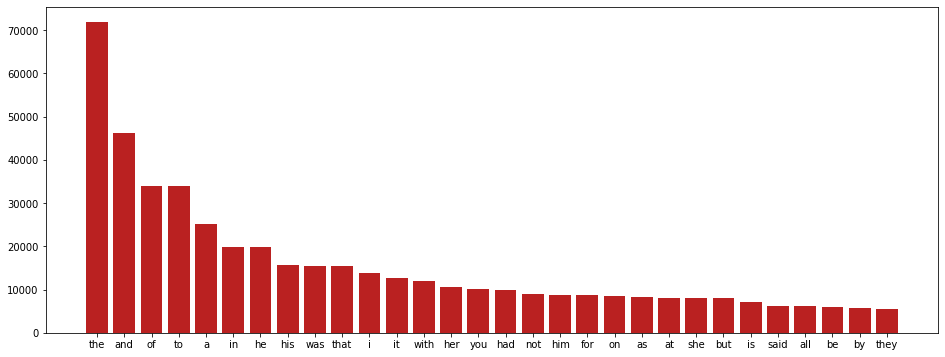

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import operator
print ('Plotting...')
freq = {}

# Read input and sort by frequency. Keep only top 30.
with open('results.txt', 'r') as csvfile:
    for line in csvfile.readlines():
        word, count = line.split('\t')
        freq[word] = int(count)
srt = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)[:30]

# Generate plot
plt.figure(figsize=(16,6))
plt.bar(range(len(srt)), [x[1] for x in srt], align='center', color='#ba2121')
plt.xticks(range(len(srt)), [x[0] for x in srt])
plt.show()

In everything is correct, the 3 most frequent words should be **`the`**, **`of`** and **`and`**.

### 1.7 Visualizing the MapReduce job

Now that we have launched our first job we can explore on the __Ambari__ dashboard the CPU and memory consumption and the details of our job.  
Access the Ambari Dashboard by clicking __Ambari home__ (see image) from your cluster overview page (on the azure dashboard __all resources__ in the left menu, select your cluster in the list, it is an __HDInsight__ resource).
![access_ambari](https://bigdataforengineers2021.blob.core.windows.net/exercise07/access_ambari.png)  
Then from the Ambari homepage you can use the __Mapreduce2__ service to see the job history or the __YARN__ service to see the current resource usage and monitor current jobs.  
![ambari_home](https://bigdataforengineers2021.blob.core.windows.net/exercise07/ambari_home.png)  
Go to MapReduce service and access the job history under "Quick Links" &gt; first link &gt; "JobHistory UI".
![mapreduce_home](https://bigdataforengineers2021.blob.core.windows.net/exercise07/mr-home.png)  
From this interface you can explore the executed jobs, the result of the jobs, the number of mapper and reducer tasks used and a lot of other useful information.
![mapreduce](https://bigdataforengineers2021.blob.core.windows.net/exercise07/mr.png)

Now we will try to launch our job again and monitor it live with the YARN service. First from the Ambari interface access the __YARN__ service and then again from "Quick Links" &gt; choose the "active" node &gt; "ResourceManager UI".
![yarn_home](https://bigdataforengineers2021.blob.core.windows.net/exercise07/yarn-home.png)  
![yarn](https://bigdataforengineers2021.blob.core.windows.net/exercise07/yarn.png) 
YARN is a complex framework that handles resource management on the cluster. You will get to know more about it during the YARN lecture, but for now we will just use it to monitor our MapReduce job live.  
Now from the ssh shell run again the same MapReduce job, but remember to change the output folder to a new name, otherwise the job will fail because the folder already exists.  
```
hadoop jar /usr/hdp/current/hadoop-mapreduce-client/hadoop-streaming.jar \
-numReduceTasks 4 \
-mapper ./mapper.py \
-reducer ./reducer.py \
-input /tmp/books/* \
-output /tmp/output-folder-3 \
-file ./reducer.py  \
-file ./mapper.py 
```

If you now go to your dashboard and refresh the browser, you will see a new running job and by clicking on it you can examine step by step the resources used by the various tasks and the progress of our job. This is particularly useful to monitor and debug our application and examine for example the performance of the different nodes on our cluster.

This was all for the hands-on part! Exit the shell and finally

### <span style="color: #C00000;">1.8 DELETE THE CLUSTER</span>
As always, this cluster burns a lot of money so delete it now!  
From the dashboard click in the left menu 'All resources', check the 'HDInsight' cluster resource in the list and click 'delete' in the top menu, confirm that you want to delete the resource and **DELETE** it!

## 2. Understanding MapReduce's execution model

For each of the following statements, state whether it is *true* or *false* and briefly explain why.

1. Each mapper task must generate the same number of key/value pairs as its input had.
2. The TaskTracker is responsible for scheduling mapper and reducer tasks and make sure all nodes are correctly running.
3. Mappers input key/value pairs are sorted by the key.
4. MapReduce splits might not correspond to HDFS block.
5. One single Reducer task is applied to all values associated with the same key.
6. Multiple Reducer tasks can be assigned pairs with the same value.
7. In Hadoop MapReduce, the key-value pairs a Reducer outputs must be of the same type as its input pairs.

**Solution**

1. **False** - for each input pair, the mapper can emit zero, one or several key/value pairs.
2. **False** - the JobTracker is responsible for this.
3. **False** - mapper input is not sorted.
4. **True** - since splits respects logical record boundaries, they might contain data from multiple HDFS blocks.
5. **True** - this is the principle behind partitioning: one Reducer task is responsible for all values associated with a particular key.
6. **True** - values are not relevant in partitioning.
7. **False** - Reducer's input and output pairs might have different types.

## 3. A comprehension task
Conceptually, a map function takes in input a kay-value pair and emits a list of key-values pairs, while a reduce function takes in input a key with an associated list of values and returns a list of values or key-value pairs. Often the type of the final key and value is the same of the type of the intermediate data:

- map     `(k1,v1) --> list(k2,v2)`
- reduce  `(k2,list(v2))--> list(k2, v2)`

Analyze the following Mapper and Reducer functions, written in pseudo-code, and answer the questions below.

```js
function map(key, value)
  emit(key, value);
```

```js
function reduce(key, values[])
  z = 0.0
  for value in values:
    z += value
  emit(key, z / values.length())
```

** Questions **
1. Explain what is the result of running this job on a list of pairs with type ([string], [float]).
2. Could you use this reduce function as combiner as well? Why or why not?
3. If your answer to the previous question was *yes*, does the number of different keys influences the effectiveness of the combiner? If you answer was *no*, can you change (if needed) map and reduce functions in such a way the new reducer the can be used as combiner?

**Solution**

1. This will output a pair `(k1, v1)` for each unique input key, where `k1` is the input key and `v1` is the average of the values associated with `k1`
2. No, because the average operation is not associative.
3. If we allow the final output to contain an additional piece of information (how many samples the average represents), the reducer can be used as combiner, with the values being themselves a pair:

```js
function map(key, value)
  emit(key, (1, value));

function reduce(key, values[])
  n = 0
  z = 0.0
  for value in values:
    n += value[0]
    z += value[0] * value[1]
  emit(key, (n, z / n))
```

## Own Exploration

Imagine you are given a dataset with the temperatures and precipitations around the world for a given day.  
The initial KV pairs consists of `(line number in the file) -> (country,station_id,avg_temperature,mm_of_rain)`.  
You can assume that all station IDs are distinct.   
Write a MapReduce job (using pseudocode as seen in task 3) for each of the following problems, also state whether it is possible to use a combiner to speed up the computation.

1. Find for each country except the UK the maximum avg_temperature  
2. Find for each country the station_id with the maximum avg_temperature  
3. Find for each country the total amount of mm_of_rain but only for countries for which the total is greater than 100mm  
4. Find for each country the total amount of mm_of_rain from stations in which it rained more than 10mm  

**Solution**


1.
```js
function map(key, value)
    country,station_id,avg_temperature,mm_of_rain = value
    if country != "UK":
        emit(country, avg_temperature)

    function reduce(key, values[])
    max_temp = value[0]
    for value in values:
        max_temp = max(max_temp,value)
    emit(key, max_temp)
```
2.
```js
function map(key, value)
    country,station_id,avg_temperature,mm_of_rain = value
    emit(country, (station_id,avg_temperature))

    function reduce(key, values[])
    station_max,max_temp = value[0]
    for station_id,temp in values:
        if temp > max_temp:
            max_temp = temp
            station_max = station_id
    emit(key, station_max)
```
3.
```js
function map(key, value)
    country,station_id,avg_temperature,mm_of_rain = value
    emit(country, mm_of_rain)

    function reduce(key, values[])
    tot_rain = 0
    for value in values:
        tot_rain += value
    if tot_rain > 100:
        emit(key, tot_rain)
```
4.
```js
function map(key, value)
    country,station_id,avg_temperature,mm_of_rain = value
    if mm_of_rain > 10:
        emit(country, mm_of_rain)

    function reduce(key, values[])
    tot_rain = 0
    for value in values:
        tot_rain += value
    emit(key, tot_rain)
```
